# Import Libraries

In [1]:
import pandas as pd
import warnings
import numpy as np
from numpy import where
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import ADASYN
from collections import Counter

warnings.filterwarnings('ignore')

### Methods for plotting the ROC Curve graph and getting classification score

In [2]:
def plot_roc(fpr,tpr):
    plt.plot(fpr, tpr, color='green', label='ROC')
    plt.plot([0, 1], [0, 1], color='yellow', linestyle='--')
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

def classification_score(clf, x_test, y_test):
    prob = clf.predict_proba(x_test)
    prob = prob[:, 1]
    auc = roc_auc_score(y_test, prob)    
    print('AUC: %.2f' % auc)
    fpr, tpr, thresholds = roc_curve(y_test, prob, pos_label=None)
    plot_roc(fpr,tpr)
    predicted = clf.predict(x_test)
    report = classification_report(y_test, predicted)
    return report

# Read datasets in data frames

In [3]:
ccrecord = pd.read_csv('./credit_record.csv')
apprecord = pd.read_csv('./application_record.csv')

In [4]:
ccrecord.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [5]:
ccrecord.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ID              1048575 non-null  int64 
 1   MONTHS_BALANCE  1048575 non-null  int64 
 2   STATUS          1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


In [6]:
# Check for Unique values of ID
ccrecord['ID'].nunique()

45985

This dataframe contains the target variable 'STATUS'. There are total 45985 unique IDs in the credit record dataset

In [7]:
ccrecord.shape

(1048575, 3)

The total number of records in the credit record dataset are 1,048,573 and there are total 3 columns  

## Transform the the Status values

In [8]:
ccrecord['STATUS'].replace('X', 0, inplace=True)     # Paid of in current month
ccrecord['STATUS'].replace('C', 0, inplace=True)     # No Loan in the month
ccrecord['STATUS'] = ccrecord['STATUS'].astype('int')

The target column 'STATUS' has been transformed to group the 'X' and 'C' status values under class - 0 as non risky applicants. 

## Remove duplicate records of ID and keep the one with worst status

In [9]:
credit_record = ccrecord.sort_values(by=['ID', 'STATUS'],ascending=[True, False]).drop_duplicates('ID',keep='first').reset_index(drop=True)
credit_record.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,0
1,5001712,0,0
2,5001713,0,0
3,5001714,0,0
4,5001715,0,0


In [10]:
# check the unique status field values
credit_record.STATUS.value_counts()

0    40635
1     4683
2      336
5      195
3       88
4       48
Name: STATUS, dtype: int64

In [11]:
# check the dataset data types
apprecord.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

Application records dataset contains total 438,557 rows and 18 columns

In [12]:
# check unique ID values in application record 
apprecord['ID'].nunique()

438510

It contains 438,510 unique records by ID column

## Merge the application record and credit record datasets on matching 'ID' column field

In [13]:
# merge application and credit record datasets on 'ID' column
df = pd.merge(apprecord, credit_record, how='inner', on=['ID'])

In [14]:
df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-13,1
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-12,1
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,0,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-22,0


In [15]:
df.shape

(36457, 20)

The merged dataset has total 20 rows and 36,457 rows  

In [16]:
# find unique values under 'STATUS' column
df['STATUS'].value_counts()

0    32166
1     3675
2      314
5      180
3       76
4       46
Name: STATUS, dtype: int64

In [17]:
# Transform the STATUS field values - any Status value >= 1 is transformed to 1 because it's a Target column
df['STATUS'] = df['STATUS'].apply(pd.to_numeric) 
df['STATUS'] = np.where(df['STATUS']<1, 0, 1)
print(df['STATUS'].value_counts())

0    32166
1     4291
Name: STATUS, dtype: int64


All the risk free cases have been grouped under class - 0 and all the risky cases are grouped under class - 1. class 0 represents the good customers and class 1 represents the bad customers 

<b>88.23% cases are no risk cases and 11.77% are risk cases</b>

## Check for missing values

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36457 entries, 0 to 36456
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   36457 non-null  int64  
 1   CODE_GENDER          36457 non-null  object 
 2   FLAG_OWN_CAR         36457 non-null  object 
 3   FLAG_OWN_REALTY      36457 non-null  object 
 4   CNT_CHILDREN         36457 non-null  int64  
 5   AMT_INCOME_TOTAL     36457 non-null  float64
 6   NAME_INCOME_TYPE     36457 non-null  object 
 7   NAME_EDUCATION_TYPE  36457 non-null  object 
 8   NAME_FAMILY_STATUS   36457 non-null  object 
 9   NAME_HOUSING_TYPE    36457 non-null  object 
 10  DAYS_BIRTH           36457 non-null  int64  
 11  DAYS_EMPLOYED        36457 non-null  int64  
 12  FLAG_MOBIL           36457 non-null  int64  
 13  FLAG_WORK_PHONE      36457 non-null  int64  
 14  FLAG_PHONE           36457 non-null  int64  
 15  FLAG_EMAIL           36457 non-null 

In [19]:
# Get the missing values percentage
df.isnull().sum()*100/len(df)

ID                      0.000000
CODE_GENDER             0.000000
FLAG_OWN_CAR            0.000000
FLAG_OWN_REALTY         0.000000
CNT_CHILDREN            0.000000
AMT_INCOME_TOTAL        0.000000
NAME_INCOME_TYPE        0.000000
NAME_EDUCATION_TYPE     0.000000
NAME_FAMILY_STATUS      0.000000
NAME_HOUSING_TYPE       0.000000
DAYS_BIRTH              0.000000
DAYS_EMPLOYED           0.000000
FLAG_MOBIL              0.000000
FLAG_WORK_PHONE         0.000000
FLAG_PHONE              0.000000
FLAG_EMAIL              0.000000
OCCUPATION_TYPE        31.058507
CNT_FAM_MEMBERS         0.000000
MONTHS_BALANCE          0.000000
STATUS                  0.000000
dtype: float64

<b>OCCUPATION_TYPE column has 31% null values so we impute the missing value with 'Unknown'</b>

In [20]:
df['OCCUPATION_TYPE'] = df['OCCUPATION_TYPE'].fillna('Unknown')
df['OCCUPATION_TYPE'].value_counts()

Unknown                  11323
Laborers                  6211
Core staff                3591
Sales staff               3485
Managers                  3012
Drivers                   2138
High skill tech staff     1383
Accountants               1241
Medicine staff            1207
Cooking staff              655
Security staff             592
Cleaning staff             551
Private service staff      344
Low-skill Laborers         175
Waiters/barmen staff       174
Secretaries                151
HR staff                    85
Realty agents               79
IT staff                    60
Name: OCCUPATION_TYPE, dtype: int64

### Find the list of categorical columns

In [21]:
# list of columns whose data type is object i.e. string
filteredColumns = df.dtypes[df.dtypes == np.object]
non_numeric_cols = list(filteredColumns.index)
print(non_numeric_cols)

['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE']


The list of categorical columns are - 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE'

## Transform the 'DAYS_EMPLOYED' and 'DAYS_BIRTH' to year values and drop 'FLAG_MOBIL' column

In [22]:
df['Age'] = -df['DAYS_BIRTH'] // 365.25
df['Experience'] = -df['DAYS_EMPLOYED'] // 365.25
print(df['Age'].head())
print(df['Experience'].head())
df.loc[df['Experience']<0, 'Experience'] = np.nan
df['Experience'].fillna(df['Experience'].mean(),inplace=True) #replace na by mean
df.drop(['DAYS_BIRTH', 'DAYS_EMPLOYED'], axis=1, inplace=True)

0    32
1    32
2    58
3    52
4    52
Name: Age, dtype: int64
0    12
1    12
2     3
3     8
4     8
Name: Experience, dtype: int64


In [23]:
df['FLAG_MOBIL'].value_counts()

1    36457
Name: FLAG_MOBIL, dtype: int64

In [24]:
# Since 'FLAG_MOBIL' field has values as 1 for all the records so it doesn't contribute to determine the target variable so this can be dropped
df.drop(['FLAG_MOBIL'], axis = 1, inplace = True)

## Check the unique values of categorical columns

In [25]:
for col in non_numeric_cols:
    print('-------{}-------'.format(col))
    print(df[col].value_counts())

-------CODE_GENDER-------
F    24430
M    12027
Name: CODE_GENDER, dtype: int64
-------FLAG_OWN_CAR-------
N    22614
Y    13843
Name: FLAG_OWN_CAR, dtype: int64
-------FLAG_OWN_REALTY-------
Y    24506
N    11951
Name: FLAG_OWN_REALTY, dtype: int64
-------NAME_INCOME_TYPE-------
Working                 18819
Commercial associate     8490
Pensioner                6152
State servant            2985
Student                    11
Name: NAME_INCOME_TYPE, dtype: int64
-------NAME_EDUCATION_TYPE-------
Secondary / secondary special    24777
Higher education                  9864
Incomplete higher                 1410
Lower secondary                    374
Academic degree                     32
Name: NAME_EDUCATION_TYPE, dtype: int64
-------NAME_FAMILY_STATUS-------
Married                 25048
Single / not married     4829
Civil marriage           2945
Separated                2103
Widow                    1532
Name: NAME_FAMILY_STATUS, dtype: int64
-------NAME_HOUSING_TYPE-------
House / a

# Exploratory Data Analysis

### Univariate analysis on 'STATUS' field

Text(0.5,1,'Class distribution 0: No-Risk Vs 1: Risk')

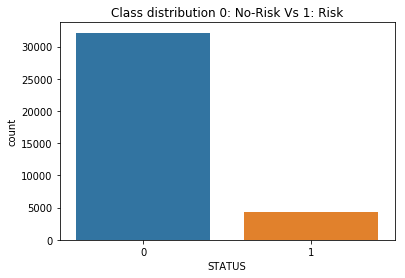

In [26]:
sns.countplot('STATUS', data=df)
plt.title('Class distribution 0: No-Risk Vs 1: Risk')

From the above plot we can see that the count of non-risky applications (class - 0) is more than risky applications (class - 1). Ratio of almost 1:7 for risky to non-risky cases. So there is a clear imbalance between these cases.

### Univariate Analysis on 'CODE_GENDER' field

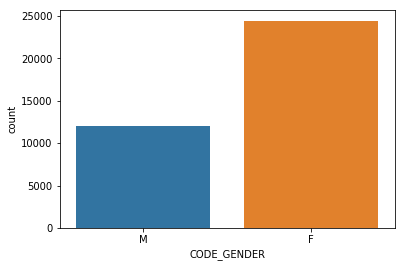

In [27]:
sns.countplot(df['CODE_GENDER'])

The above plot shows that the number of the <b>Female</b> applicants is almost double than the number of <b>Male</b> applicants 

### Univariate Analysis on 'CNT_FAM_MEMBERS' field

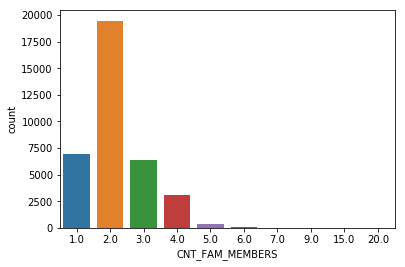

In [28]:
sns.countplot(df['CNT_FAM_MEMBERS'])

The above plot shows that the number of applicants having 2 family members is more compared to other applicants

### Univariate Analysis on 'NAME_EDUCATION_TYPE' field 

[Text(0,0,'Higher education'),
 Text(0,0,'Secondary / secondary special'),
 Text(0,0,'Incomplete higher'),
 Text(0,0,'Lower secondary'),
 Text(0,0,'Academic degree')]

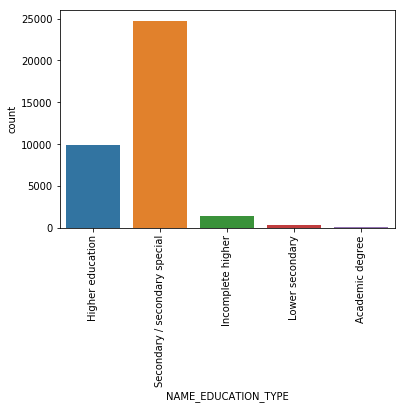

In [29]:
v = sns.countplot(df['NAME_EDUCATION_TYPE'])
v.set_xticklabels(v.get_xticklabels(), rotation=90)

The above plot shows that the most of the applicants are from education type - <b>Secondary / seondary special</b> and very less applicants having Academic degree

### Univariate Analysis on 'NAME_INCOME_TYPE' field

[Text(0,0,'Working'),
 Text(0,0,'Commercial associate'),
 Text(0,0,'Pensioner'),
 Text(0,0,'State servant'),
 Text(0,0,'Student')]

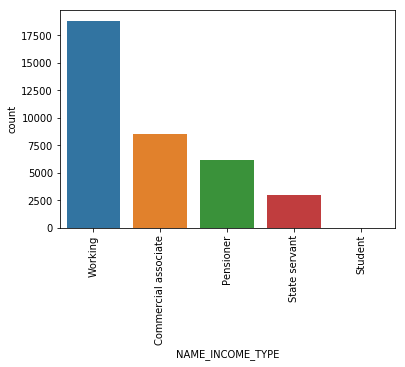

In [30]:
v = sns.countplot(df['NAME_INCOME_TYPE'])
v.set_xticklabels(v.get_xticklabels(), rotation=90)

The above trend shows that most of the most number of credit card applicants are from <b>Working</b> class

### Univariate Analysis on 'CNT_CHILDREN' field

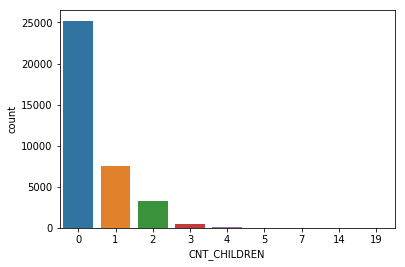

In [31]:
v = sns.countplot(df['CNT_CHILDREN'])

The above trend shows that majority of the credit card applicants have 0 children

### Univariate Analysis on 'NAME_HOUSING_TYPE' field

[Text(0,0,'Rented apartment'),
 Text(0,0,'House / apartment'),
 Text(0,0,'Municipal apartment'),
 Text(0,0,'With parents'),
 Text(0,0,'Co-op apartment'),
 Text(0,0,'Office apartment')]

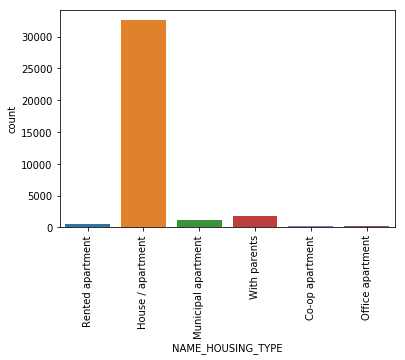

In [32]:
v = sns.countplot(df['NAME_HOUSING_TYPE'])
v.set_xticklabels(v.get_xticklabels(), rotation=90)

The above plot shows that majority of the credit card applicants are staying in the <b>House/apartment</b>

### Univariate Analysis on 'OCCUPATION_TYPE' field

[Text(0,0,'Unknown'),
 Text(0,0,'Security staff'),
 Text(0,0,'Sales staff'),
 Text(0,0,'Accountants'),
 Text(0,0,'Laborers'),
 Text(0,0,'Managers'),
 Text(0,0,'Drivers'),
 Text(0,0,'Core staff'),
 Text(0,0,'High skill tech staff'),
 Text(0,0,'Cleaning staff'),
 Text(0,0,'Private service staff'),
 Text(0,0,'Cooking staff'),
 Text(0,0,'Low-skill Laborers'),
 Text(0,0,'Medicine staff'),
 Text(0,0,'Secretaries'),
 Text(0,0,'Waiters/barmen staff'),
 Text(0,0,'HR staff'),
 Text(0,0,'Realty agents'),
 Text(0,0,'IT staff')]

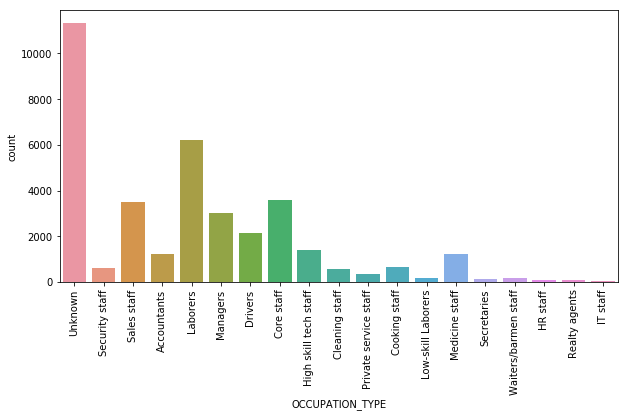

In [33]:
plt.figure(figsize=(10, 5))
g = sns.countplot(df['OCCUPATION_TYPE'])
g.set_xticklabels(g.get_xticklabels(), rotation=90)

The above trend shows that most of the applicants are from an 'Unknown' occupation type and very less applicants are from 'IT Staff' occupation type

### Univariate Analysis on 'FLAG_OWN_CAR' field

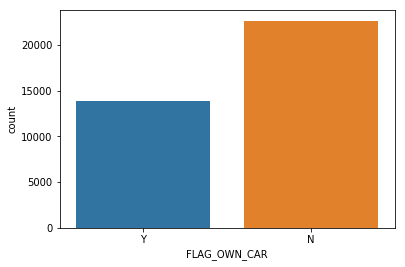

In [34]:
sns.countplot(df['FLAG_OWN_CAR'])

The above trend shows that there are more number of applicants who do not have the car as compared to the ones who own it

### Univariate Analysis on 'AMT_INCOME_TOTAL' field

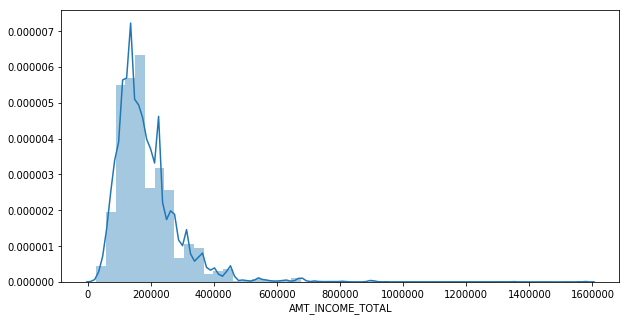

In [35]:
plt.figure(figsize=(10, 5))
g = sns.distplot(df['AMT_INCOME_TOTAL'])
# g.set_xticklabels(g.get_xticklabels(), rotation=90)

This histogram shows that most of the applicants are having income below 200000

### Bivariate Analysis on 'STATUS' and 'Age' fields

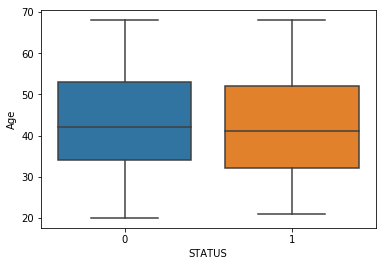

In [36]:
sns.boxplot(x = 'STATUS', y = 'Age', data = df)

The above plot gives below insights:
1. More than 50% of the customers falling under the good applicants category (class - 0) are having average age 40+ years.
2. More than 50% of the customers having the 30-59 days overdue on the loan installment payments are having average age 40+ years.
3. More than 50% of the customers having the 60-89 days overdue on the loan installment payments are having average age around 40 years.
4. More than 50% of the customers having the 90-119 days overdue on the loan installment payments are having average age 45+ years.
5. More than 50% of the customers having the 120-149 days overdue on the loan installment payments are having average age around 30 years.
6. More than 50% of the customers having the overdue or bad debts, write-offs for more than 150 days on the loan installment payments are having average age around 45+ years.

## Encode the categorical features to convert them to numeric features

In [37]:
# We will use label encoder to change the object variables to numeric variable:
le = LabelEncoder()
for col in df:
    if df[col].dtypes=='object':
        df[col] = le.fit_transform(df[col])

### Check for the sample 5 rows and describe the data

In [38]:
df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS,Age,Experience
0,5008804,1,1,1,0,427500.0,4,1,0,4,1,0,0,17,2.0,-13,1,32,12.0
1,5008805,1,1,1,0,427500.0,4,1,0,4,1,0,0,17,2.0,-12,1,32,12.0
2,5008806,1,1,1,0,112500.0,4,4,1,1,0,0,0,16,2.0,0,0,58,3.0
3,5008808,0,0,1,0,270000.0,0,4,3,1,0,1,1,14,1.0,0,0,52,8.0
4,5008809,0,0,1,0,270000.0,0,4,3,1,0,1,1,14,1.0,-22,0,52,8.0


In [39]:
df.describe()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS,Age,Experience
count,3.645700e+04,36457.000000,36457.000000,36457.000000,36457.000000,3.645700e+04,36457.000000,36457.000000,36457.000000,36457.000000,36457.000000,36457.000000,36457.000000,36457.000000,36457.000000,36457.000000,36457.000000,36457.000000,36457.000000
mean,5.078227e+06,0.329895,0.379708,0.672189,0.430315,1.866857e+05,2.398195,3.097183,1.367885,1.282881,0.225526,0.294813,0.089722,10.595880,2.198453,-7.517267,0.117700,43.232027,6.748433
std,4.187524e+04,0.470181,0.485321,0.469422,0.742367,1.017892e+05,1.734032,1.341292,0.954557,0.951675,0.417934,0.455965,0.285787,5.617823,0.911686,12.697431,0.322257,11.503981,5.896642
min,5.008804e+06,0.000000,0.000000,0.000000,0.000000,2.700000e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-60.000000,0.000000,20.000000,0.000000
25%,5.042028e+06,0.000000,0.000000,0.000000,0.000000,1.215000e+05,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,6.000000,2.000000,-11.000000,0.000000,34.000000,3.000000
50%,5.074614e+06,0.000000,0.000000,1.000000,0.000000,1.575000e+05,4.000000,4.000000,1.000000,1.000000,0.000000,0.000000,0.000000,10.000000,2.000000,0.000000,0.000000,42.000000,6.000000
75%,5.115396e+06,1.000000,1.000000,1.000000,1.000000,2.250000e+05,4.000000,4.000000,1.000000,1.000000,0.000000,1.000000,0.000000,17.000000,3.000000,0.000000,0.000000,53.000000,8.000000
max,5.150487e+06,1.000000,1.000000,1.000000,19.000000,1.575000e+06,4.000000,4.000000,4.000000,5.000000,1.000000,1.000000,1.000000,18.000000,20.000000,0.000000,1.000000,68.000000,43.000000


In [40]:
# drop ID column which is not useful in the further analysis
df.drop(['ID'], axis=1, inplace=True)

In [41]:
cols = df.columns.tolist()

In [42]:
cols

['CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'FLAG_WORK_PHONE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'MONTHS_BALANCE',
 'STATUS',
 'Age',
 'Experience']

# Correlation plot on the label encoded dataset 

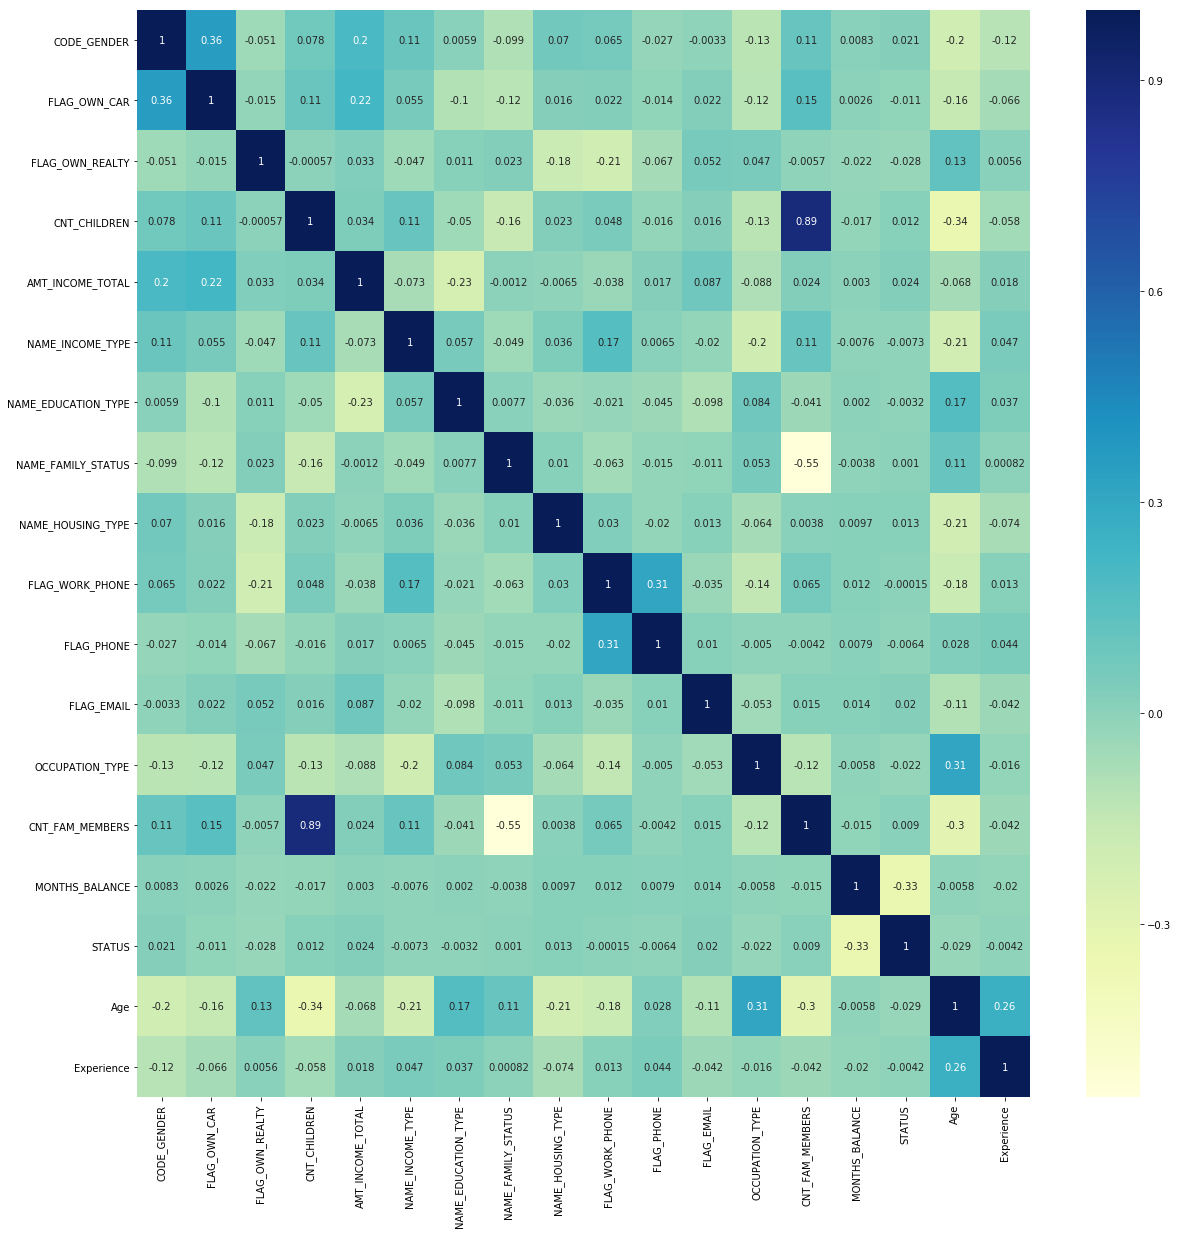

In [43]:
corrMatrix = df.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corrMatrix, annot=True, cmap="YlGnBu")
plt.show()

As per the heatmap, we can say that - The variables CNT_FAM_MEMBERS and CNT_CHILDREN have strong correlation.

### Histogram of all the fields 

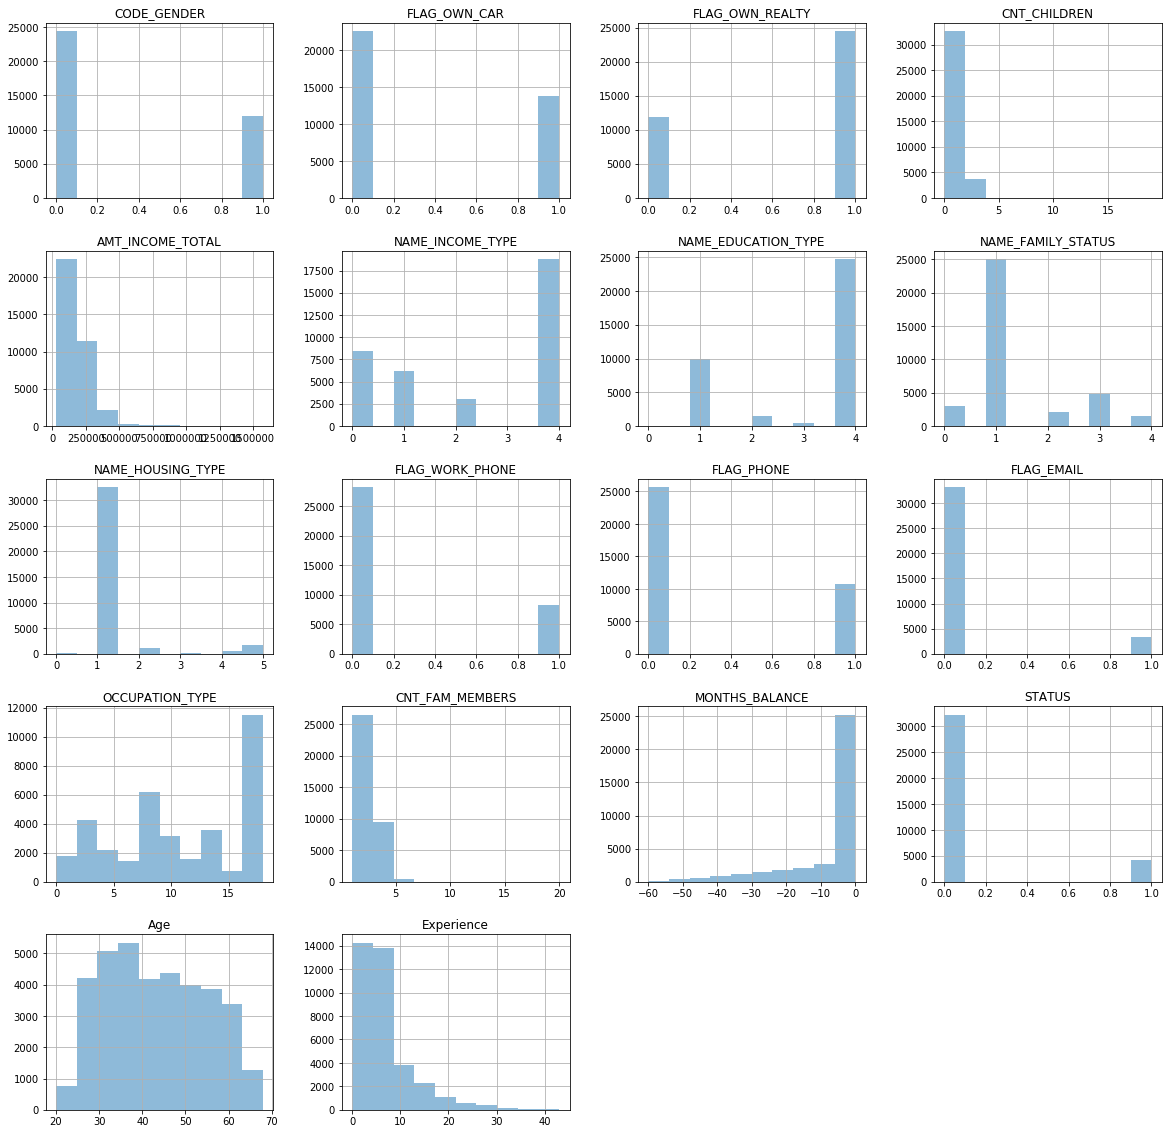

In [44]:
# Plotting the histograms of each variable
df.hist(alpha=0.5, figsize=(20, 20))
plt.show()

<b>The plot shows the data distribution of all the features in terms of bins</b>

## Get the important features using Random Forest 

Text(0.5,0,'Random Forest Feature Importance')

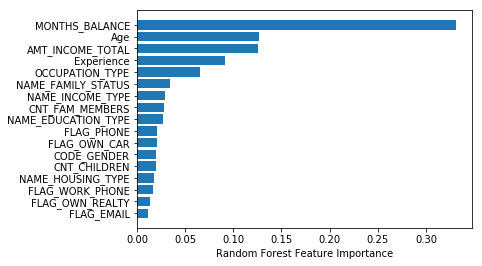

In [45]:
y = df['STATUS']
X = df.drop(['STATUS'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
rfp = RandomForestClassifier(n_estimators = 1000, random_state = 42)
rfp.fit(X_train, y_train)
sorted_idx = rfp.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx], rfp.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

In [46]:
imp_cols = ['AMT_INCOME_TOTAL', 'OCCUPATION_TYPE', 'Age', 'Experience', 'MONTHS_BALANCE' ]

<b>The Feature Importance has selected the features contributing in determining the target variable are as below: <br/>
'AMT_INCOME_TOTAL', 
'OCCUPATION_TYPE', 
'Age', 
'Experience', 
'MONTHS_BALANCE'
</b> <br>
These features are used further in building the models

## Logistic Regression on unscaled and imbalanced data

train score - 0.8772679180218661
test_score - 0.8726458219052843
AUC: 0.72


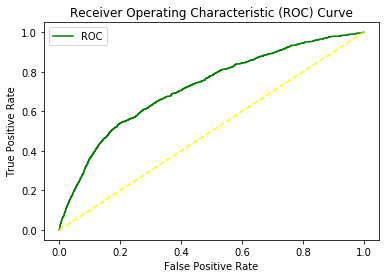

              precision    recall  f1-score   support

           0       0.89      0.98      0.93      9601
           1       0.40      0.09      0.14      1337

    accuracy                           0.87     10938
   macro avg       0.64      0.53      0.54     10938
weighted avg       0.83      0.87      0.83     10938



In [47]:
logReg = LogisticRegression()
logReg.fit(X_train, y_train)
train_score = logReg.score(X_train, y_train)
test_score = logReg.score(X_test, y_test)
print('train score - {}'.format(train_score))
print('test_score - {}'.format(test_score))
print(classification_score(logReg, X_test, y_test))

## Random Forest Classifier on imbalanced data

train score - 0.994474705121674
test_score - 0.8995245931614555
AUC: 0.89


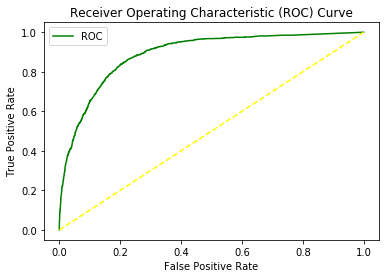

              precision    recall  f1-score   support

           0       0.92      0.98      0.94      9601
           1       0.67      0.36      0.46      1337

    accuracy                           0.90     10938
   macro avg       0.79      0.67      0.70     10938
weighted avg       0.89      0.90      0.89     10938



In [48]:
# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(X_train, y_train)
train_score = rf.score(X_train, y_train)
test_score = rf.score(X_test, y_test)
print('train score - {}'.format(train_score))
print('test_score - {}'.format(test_score))
print(classification_score(rf, X_test, y_test))

## XGBoost Classifier on imbalanced data 

[09:29:40] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
train score - 0.9939652807711901
test_score - 0.8892850612543427
AUC: 0.86


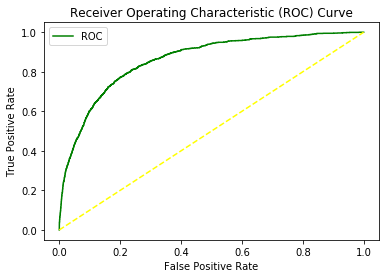

              precision    recall  f1-score   support

           0       0.92      0.96      0.94      9601
           1       0.57      0.40      0.47      1337

    accuracy                           0.89     10938
   macro avg       0.74      0.68      0.70     10938
weighted avg       0.88      0.89      0.88     10938



In [49]:
from xgboost import XGBClassifier
xgb = XGBClassifier(n_estimators = 1000, random_state = 42)
xgb.fit(X_train, y_train)
train_score = xgb.score(X_train, y_train)
test_score = xgb.score(X_test, y_test)
print('train score - {}'.format(train_score))
print('test_score - {}'.format(test_score))
print(classification_score(xgb, X_test, y_test))

## K Neighbors Classifier on imbalanced data

train score - 0.9088522277518711
test_score - 0.8713658804168952
AUC: 0.74


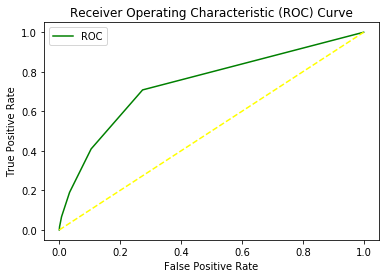

              precision    recall  f1-score   support

           0       0.90      0.97      0.93      9601
           1       0.44      0.19      0.27      1337

    accuracy                           0.87     10938
   macro avg       0.67      0.58      0.60     10938
weighted avg       0.84      0.87      0.85     10938



In [50]:
knn = KNeighborsClassifier() 
knn.fit(X_train, y_train)
train_score = knn.score(X_train, y_train)
test_score = knn.score(X_test, y_test)
print('train score - {}'.format(train_score))
print('test_score - {}'.format(test_score))
print(classification_score(knn, X_test, y_test))

## Decision Tree Classifier on imbalanced data

train score - 0.994474705121674
test_score - 0.861766319253977
AUC: 0.67


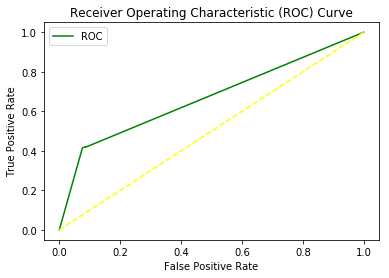

              precision    recall  f1-score   support

           0       0.92      0.92      0.92      9601
           1       0.43      0.42      0.42      1337

    accuracy                           0.86     10938
   macro avg       0.68      0.67      0.67     10938
weighted avg       0.86      0.86      0.86     10938



In [51]:
decTree = DecisionTreeClassifier() 
decTree.fit(X_train, y_train)
train_score = decTree.score(X_train, y_train)
test_score = decTree.score(X_test, y_test)
print('train score - {}'.format(train_score))
print('test_score - {}'.format(test_score))
print(classification_score(decTree, X_test, y_test))

## Scale the data using StandardScaler

In [52]:
sc = StandardScaler()
X_scaled = pd.DataFrame(sc.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(sc.transform(X_test), columns=X_test.columns)

Scaling helps while using logistic regression and K Neighbors based modeling wherein it has no impact on the tree based algorithms such as Decision Tree, Random Forest and XGBoost based classifiers because these are not sensitive to feature scaling. Because of the class imbalance, there is a need to check the model performance by using minority class oversampling techniques such as SMOTE and ADASYN and majority class undersampling using RandomUnderSampler

## Balance the minority class data with majority class by oversampling it using SMOTE

In [53]:
oversample = SMOTE()
X_balanced_sm, y_balanced_sm = oversample.fit_resample(X_scaled, y_train)
X_test_balanced_sm, y_test_balanced_sm = oversample.fit_resample(X_test_scaled, y_test)

In [54]:
y_train.value_counts()

0    22565
1     2954
Name: STATUS, dtype: int64

In [55]:
y_balanced_sm.value_counts()

1    22565
0    22565
Name: STATUS, dtype: int64

In [56]:
y_test.value_counts()

0    9601
1    1337
Name: STATUS, dtype: int64

In [57]:
y_test_balanced_sm.value_counts()

1    9601
0    9601
Name: STATUS, dtype: int64

## Logistic Regression on scaled data and balanced using SMOTE

train score - 0.7159539109239973
test_score - 0.7146130611394647
AUC: 0.80


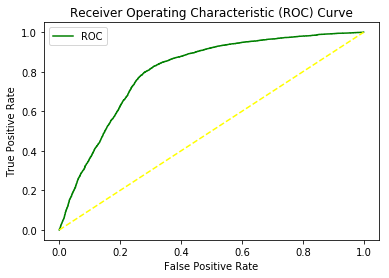

              precision    recall  f1-score   support

           0       0.68      0.80      0.74      9601
           1       0.76      0.63      0.69      9601

    accuracy                           0.71     19202
   macro avg       0.72      0.71      0.71     19202
weighted avg       0.72      0.71      0.71     19202



In [58]:
logReg = LogisticRegression()
logReg.fit(X_balanced_sm, y_balanced_sm)
train_score = logReg.score(X_balanced_sm, y_balanced_sm)
test_score = logReg.score(X_test_balanced_sm, y_test_balanced_sm)
print('train score - {}'.format(train_score))
print('test_score - {}'.format(test_score))
print(classification_score(logReg, X_test_balanced_sm, y_test_balanced_sm))

## Random Forest Classifier on data balanced using SMOTE

train score - 0.9968092178152005
test_score - 0.9055827517966878
AUC: 0.97


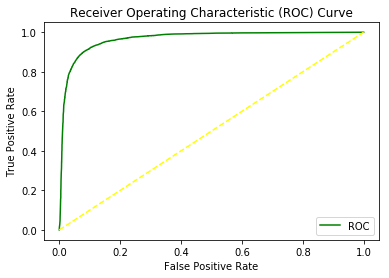

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      9601
           1       0.94      0.87      0.90      9601

    accuracy                           0.91     19202
   macro avg       0.91      0.91      0.91     19202
weighted avg       0.91      0.91      0.91     19202



In [59]:
classifier = RandomForestClassifier(n_estimators = 1000, random_state = 42)
classifier.fit(X_balanced_sm, y_balanced_sm)
train_score = classifier.score(X_balanced_sm, y_balanced_sm)
test_score = classifier.score(X_test_balanced_sm, y_test_balanced_sm)
print('train score - {}'.format(train_score))
print('test_score - {}'.format(test_score))
print(classification_score(classifier, X_test_balanced_sm, y_test_balanced_sm))

## XGBoost Classifier on data balanced using SMOTE

[09:31:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
train score - 0.996454686461334
test_score - 0.9312050828038746
AUC: 0.98


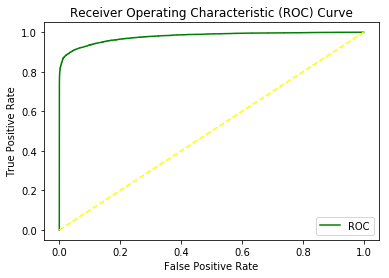

              precision    recall  f1-score   support

           0       0.91      0.95      0.93      9601
           1       0.95      0.91      0.93      9601

    accuracy                           0.93     19202
   macro avg       0.93      0.93      0.93     19202
weighted avg       0.93      0.93      0.93     19202



In [60]:
from xgboost import XGBClassifier
xgb = XGBClassifier(n_estimators = 1000, random_state = 42)
model = xgb.fit(X_balanced_sm, y_balanced_sm)
train_score = model.score(X_balanced_sm, y_balanced_sm)
test_score = model.score(X_test_balanced_sm, y_test_balanced_sm)
print('train score - {}'.format(train_score))
print('test_score - {}'.format(test_score))
print(classification_score(xgb, X_test_balanced_sm, y_test_balanced_sm))

## K Neighbors Classifier on scaled data and balanced using SMOTE 

train score - 0.9343230666962109
test_score - 0.7411207165920216
AUC: 0.79


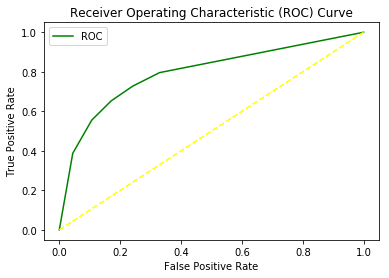

              precision    recall  f1-score   support

           0       0.70      0.83      0.76      9601
           1       0.79      0.65      0.72      9601

    accuracy                           0.74     19202
   macro avg       0.75      0.74      0.74     19202
weighted avg       0.75      0.74      0.74     19202



In [61]:
knn = KNeighborsClassifier() 
knn.fit(X_balanced_sm, y_balanced_sm)
train_score = knn.score(X_balanced_sm, y_balanced_sm)
test_score = knn.score(X_test_balanced_sm, y_test_balanced_sm)
print('train score - {}'.format(train_score))
print('test_score - {}'.format(test_score))
print(classification_score(knn, X_test_balanced_sm, y_test_balanced_sm))

## Decision Tree Classifier on data balanced using SMOTE 

train score - 0.9968092178152005
test_score - 0.8742839287574211
AUC: 0.87


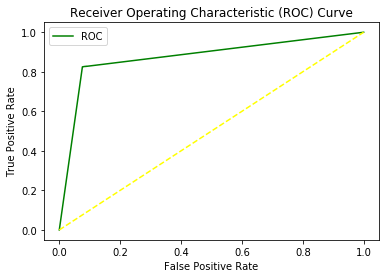

              precision    recall  f1-score   support

           0       0.84      0.92      0.88      9601
           1       0.92      0.83      0.87      9601

    accuracy                           0.87     19202
   macro avg       0.88      0.87      0.87     19202
weighted avg       0.88      0.87      0.87     19202



In [62]:
decTree = DecisionTreeClassifier() 
decTree.fit(X_balanced_sm, y_balanced_sm)
train_score = decTree.score(X_balanced_sm, y_balanced_sm)
test_score = decTree.score(X_test_balanced_sm, y_test_balanced_sm)
print('train score - {}'.format(train_score))
print('test_score - {}'.format(test_score))
print(classification_score(decTree, X_test_balanced_sm, y_test_balanced_sm))

## Undersample the majority class to balance it with minority class using RandomUnderSampler

In [63]:
undersample = RandomUnderSampler(sampling_strategy='majority')
X_balanced_us, y_balanced_us = undersample.fit_resample(X_scaled, y_train)
X_test_balanced_us, y_test_balanced_us = undersample.fit_resample(X_test_scaled, y_test)

In [64]:
y_train.value_counts()

0    22565
1     2954
Name: STATUS, dtype: int64

In [65]:
y_balanced_us.value_counts()

1    2954
0    2954
Name: STATUS, dtype: int64

In [66]:
y_test_balanced_us.value_counts()

1    1337
0    1337
Name: STATUS, dtype: int64

## Logistic Regression on scaled data and undersampled on majority class

train score - 0.7034529451591063
test_score - 0.7120418848167539
AUC: 0.79


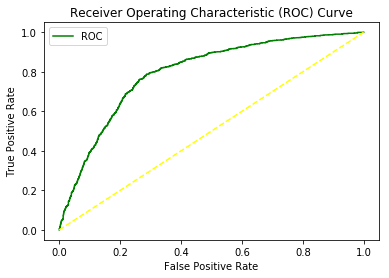

              precision    recall  f1-score   support

           0       0.68      0.81      0.74      1337
           1       0.76      0.62      0.68      1337

    accuracy                           0.71      2674
   macro avg       0.72      0.71      0.71      2674
weighted avg       0.72      0.71      0.71      2674



In [67]:
logReg = LogisticRegression()
logReg.fit(X_balanced_us, y_balanced_us)
train_score = logReg.score(X_balanced_us, y_balanced_us)
test_score = logReg.score(X_test_balanced_us, y_test_balanced_us)
print('train score - {}'.format(train_score))
print('test_score - {}'.format(test_score))
print(classification_score(logReg, X_test_balanced_us, y_test_balanced_us))

## Random Forest Classifier on data undersampled using majority class

train score - 0.993906567366283
test_score - 0.8055347793567689
AUC: 0.87


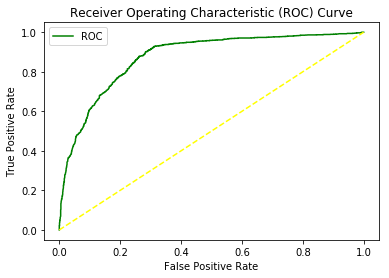

              precision    recall  f1-score   support

           0       0.85      0.74      0.79      1337
           1       0.77      0.87      0.82      1337

    accuracy                           0.81      2674
   macro avg       0.81      0.81      0.80      2674
weighted avg       0.81      0.81      0.80      2674



In [68]:
classifier = RandomForestClassifier(n_estimators = 1000, random_state = 42)
classifier.fit(X_balanced_us, y_balanced_us)
train_score = classifier.score(X_balanced_us, y_balanced_us)
test_score = classifier.score(X_test_balanced_us, y_test_balanced_us)
print('train score - {}'.format(train_score))
print('test_score - {}'.format(test_score))
print(classification_score(classifier, X_test_balanced_us, y_test_balanced_us))

## XGBoost Classifier on data undersampled using majority class 

[09:33:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
train score - 0.993906567366283
test_score - 0.7793567688855647
AUC: 0.84


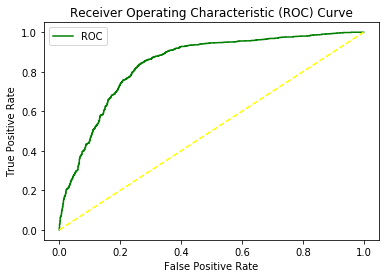

              precision    recall  f1-score   support

           0       0.79      0.76      0.77      1337
           1       0.77      0.80      0.78      1337

    accuracy                           0.78      2674
   macro avg       0.78      0.78      0.78      2674
weighted avg       0.78      0.78      0.78      2674



In [69]:
xgb = XGBClassifier(n_estimators = 1000, random_state = 42)
model = xgb.fit(X_balanced_us, y_balanced_us)
prediction = xgb.predict(X_test_balanced_us)
train_score = xgb.score(X_balanced_us, y_balanced_us)
test_score = xgb.score(X_test_balanced_us, y_test_balanced_us)
print('train score - {}'.format(train_score))
print('test_score - {}'.format(test_score))
print(classification_score(xgb, X_test_balanced_us, y_test_balanced_us))

## K Neighbors Classifier on scaled data and undersampled using majority class

train score - 0.7846987136086662
test_score - 0.6985789080029918
AUC: 0.75


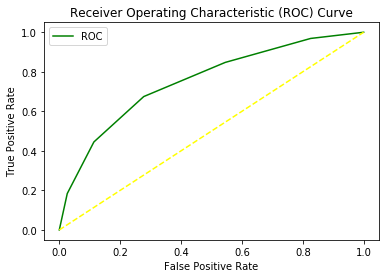

              precision    recall  f1-score   support

           0       0.69      0.72      0.71      1337
           1       0.71      0.67      0.69      1337

    accuracy                           0.70      2674
   macro avg       0.70      0.70      0.70      2674
weighted avg       0.70      0.70      0.70      2674



In [70]:
knn = KNeighborsClassifier() 
knn.fit(X_balanced_us, y_balanced_us)
train_score = knn.score(X_balanced_us, y_balanced_us)
test_score = knn.score(X_test_balanced_us, y_test_balanced_us)
y_pred_balanced = knn.predict(X_test_balanced_us)
print('train score - {}'.format(train_score))
print('test_score - {}'.format(test_score))
print(classification_score(knn, X_test_balanced_us, y_test_balanced_us))

## Decision Tree Classifier on data undersampled using majority class

train score - 0.993906567366283
test_score - 0.7161555721765146
AUC: 0.72


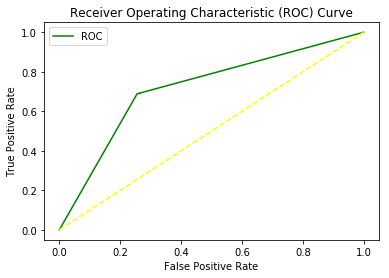

              precision    recall  f1-score   support

           0       0.70      0.74      0.72      1337
           1       0.73      0.69      0.71      1337

    accuracy                           0.72      2674
   macro avg       0.72      0.72      0.72      2674
weighted avg       0.72      0.72      0.72      2674



In [71]:
decTree = DecisionTreeClassifier() 
decTree.fit(X_balanced_us, y_balanced_us)
train_score = decTree.score(X_balanced_us, y_balanced_us)
test_score = decTree.score(X_test_balanced_us, y_test_balanced_us)
y_pred_balanced = decTree.predict(X_test_balanced_us)
print('train score - {}'.format(train_score))
print('test_score - {}'.format(test_score))
print(classification_score(decTree, X_test_balanced_us, y_test_balanced_us))

## Balance the minority class data with majority class by oversampling it using ADASYN

In [72]:
ada = ADASYN()
X_balanced_ada, y_balanced_ada = ada.fit_resample(X_scaled, y_train)
X_test_balanced_ada, y_test_balanced_ada = ada.fit_resample(X_test_scaled, y_test)

In [73]:
y_train.value_counts()

0    22565
1     2954
Name: STATUS, dtype: int64

In [74]:
y_balanced_ada.value_counts()

1    22900
0    22565
Name: STATUS, dtype: int64

In [75]:
y_test_balanced_ada.value_counts()

1    9721
0    9601
Name: STATUS, dtype: int64

## Logistic Regression on scaled data and balanced using ADASYN

train score - 0.7036181678214011
test_score - 0.7008591243142532
AUC: 0.79


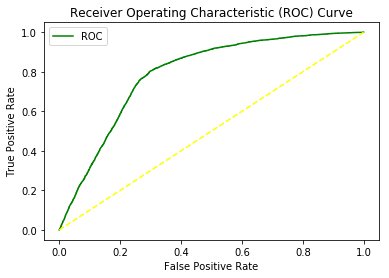

              precision    recall  f1-score   support

           0       0.67      0.79      0.72      9601
           1       0.75      0.61      0.67      9721

    accuracy                           0.70     19322
   macro avg       0.71      0.70      0.70     19322
weighted avg       0.71      0.70      0.70     19322



In [76]:
logReg = LogisticRegression()
logReg.fit(X_balanced_ada, y_balanced_ada)
train_score = logReg.score(X_balanced_ada, y_balanced_ada)
test_score = logReg.score(X_test_balanced_ada, y_test_balanced_ada)
print('train score - {}'.format(train_score))
print('test_score - {}'.format(test_score))
print(classification_score(logReg, X_test_balanced_ada, y_test_balanced_ada))

## Random Forest on data balanced using ADASYN 

train score - 0.9968107335312878
test_score - 0.9101024738639892
AUC: 0.97


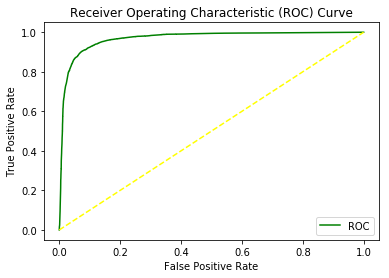

              precision    recall  f1-score   support

           0       0.89      0.94      0.91      9601
           1       0.94      0.88      0.91      9721

    accuracy                           0.91     19322
   macro avg       0.91      0.91      0.91     19322
weighted avg       0.91      0.91      0.91     19322



In [77]:
classifier = RandomForestClassifier(n_estimators = 1000, random_state = 42)
classifier.fit(X_balanced_ada, y_balanced_ada)
train_score = classifier.score(X_balanced_ada, y_balanced_ada)
test_score = classifier.score(X_test_balanced_ada, y_test_balanced_ada)
print('train score - {}'.format(train_score))
print('test_score - {}'.format(test_score))
print(classification_score(classifier, X_test_balanced_ada, y_test_balanced_ada))

## XGBoost Classifier on data balanced using ADASYN 

[09:35:27] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
train score - 0.9964808094138348
test_score - 0.9316323361970811
AUC: 0.98


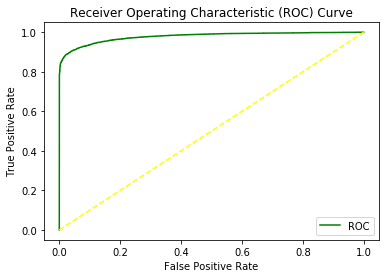

              precision    recall  f1-score   support

           0       0.91      0.96      0.93      9601
           1       0.95      0.91      0.93      9721

    accuracy                           0.93     19322
   macro avg       0.93      0.93      0.93     19322
weighted avg       0.93      0.93      0.93     19322



In [78]:
xgb = XGBClassifier(n_estimators = 1000, random_state = 42)
model = xgb.fit(X_balanced_ada, y_balanced_ada)
prediction = xgb.predict(X_test_balanced_ada)
train_score = xgb.score(X_balanced_ada, y_balanced_ada)
test_score = xgb.score(X_test_balanced_ada, y_test_balanced_ada)
print('train score - {}'.format(train_score))
print('test_score - {}'.format(test_score))
print(classification_score(xgb, X_test_balanced_ada, y_test_balanced_ada))

## K Neighbors Classifier on scaled data and balanced using ADASYN

train score - 0.9324315407456285
test_score - 0.7339819894420867
AUC: 0.79


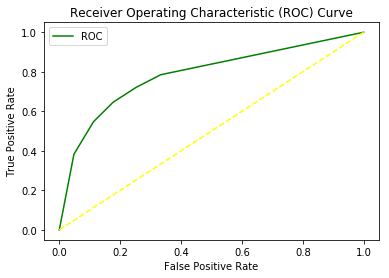

              precision    recall  f1-score   support

           0       0.70      0.82      0.75      9601
           1       0.79      0.65      0.71      9721

    accuracy                           0.73     19322
   macro avg       0.74      0.73      0.73     19322
weighted avg       0.74      0.73      0.73     19322



In [79]:
knn = KNeighborsClassifier() 
knn.fit(X_balanced_ada, y_balanced_ada)
train_score = knn.score(X_balanced_ada, y_balanced_ada)
test_score = knn.score(X_test_balanced_ada, y_test_balanced_ada)
print('train score - {}'.format(train_score))
print('test_score - {}'.format(test_score))
print(classification_score(knn, X_test_balanced_ada, y_test_balanced_ada))

## Decision Tree Classifier on data balanced using ADASYN

train score - 0.9968107335312878
test_score - 0.8843287444363938
AUC: 0.88


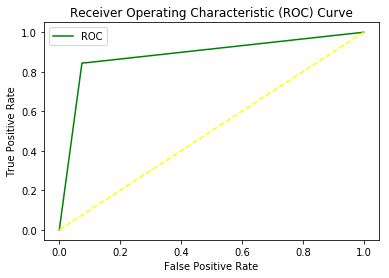

              precision    recall  f1-score   support

           0       0.85      0.93      0.89      9601
           1       0.92      0.84      0.88      9721

    accuracy                           0.88     19322
   macro avg       0.89      0.88      0.88     19322
weighted avg       0.89      0.88      0.88     19322



In [80]:
decTree = DecisionTreeClassifier() 
decTree.fit(X_balanced_ada, y_balanced_ada)
train_score = decTree.score(X_balanced_ada, y_balanced_ada)
test_score = decTree.score(X_test_balanced_ada, y_test_balanced_ada)
print('train score - {}'.format(train_score))
print('test_score - {}'.format(test_score))
print(classification_score(decTree, X_test_balanced_ada, y_test_balanced_ada))

## XGBoost on data balanced using ADASYN with tuned hyperparameters 

In [81]:
xgb = XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42
)

parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(300, 1200, 300),
    'learning_rate': [0.1, 0.01, 0.05]
}

random_search = RandomizedSearchCV(xgb, param_distributions=parameters, n_iter=5, scoring='roc_auc', n_jobs=-1, cv=5, verbose=3)
random_search.fit(X_balanced_ada, y_balanced_ada)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[10:15:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...None,
                                           nthread=4, num_parallel_tree=None,
                                           random_state=None, reg_alpha=None,
                    

In [82]:
random_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=900, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=42, subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [83]:
random_search.best_params_

{'n_estimators': 900, 'max_depth': 9, 'learning_rate': 0.1}

[10:16:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
train score - 0.9666116793137578
test_score - 0.9285270675913466
AUC: 0.98


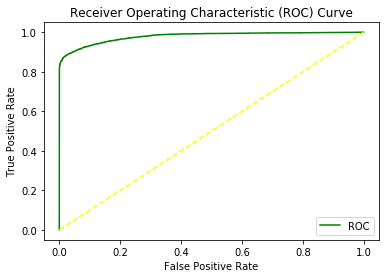

              precision    recall  f1-score   support

           0       0.90      0.96      0.93      9601
           1       0.96      0.90      0.93      9721

    accuracy                           0.93     19322
   macro avg       0.93      0.93      0.93     19322
weighted avg       0.93      0.93      0.93     19322



In [84]:
xgb = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=np.nan, monotone_constraints='()',
              n_estimators=600, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=42, subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)
model = xgb.fit(X_balanced_ada, y_balanced_ada)
prediction = xgb.predict(X_test_balanced_ada)
train_score = xgb.score(X_balanced_ada, y_balanced_ada)
test_score = xgb.score(X_test_balanced_ada, y_test_balanced_ada)
print('train score - {}'.format(train_score))
print('test_score - {}'.format(test_score))
print(classification_score(xgb, X_test_balanced_ada, y_test_balanced_ada))

## XGBoost on data balanced using SMOTE with tuned hyperparameters 

In [85]:
xgb = XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42
)

parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(300, 1200, 300),
    'learning_rate': [0.1, 0.01, 0.05]
}

random_search = RandomizedSearchCV(xgb, param_distributions=parameters, n_iter=5, scoring='roc_auc', n_jobs=-1, cv=5, verbose=3)
random_search.fit(X_balanced_sm, y_balanced_sm)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[11:29:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...None,
                                           nthread=4, num_parallel_tree=None,
                                           random_state=None, reg_alpha=None,
                    

In [86]:
random_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=900, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=42, subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [87]:
random_search.best_params_

{'n_estimators': 900, 'max_depth': 9, 'learning_rate': 0.1}

[11:29:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
train score - 0.9667405273653888
test_score - 0.9269346943026768
AUC: 0.98


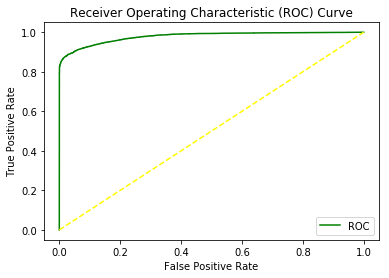

              precision    recall  f1-score   support

           0       0.90      0.96      0.93      9601
           1       0.96      0.89      0.92      9601

    accuracy                           0.93     19202
   macro avg       0.93      0.93      0.93     19202
weighted avg       0.93      0.93      0.93     19202



In [88]:
xgb = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=np.nan, monotone_constraints='()',
              n_estimators=600, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=42, subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)
model = xgb.fit(X_balanced_sm, y_balanced_sm)
prediction = xgb.predict(X_test_balanced_sm)
train_score = xgb.score(X_balanced_sm, y_balanced_sm)
test_score = xgb.score(X_test_balanced_sm, y_test_balanced_sm)
print('train score - {}'.format(train_score))
print('test_score - {}'.format(test_score))
print(classification_score(xgb, X_test_balanced_sm, y_test_balanced_sm))

# Conclusions

1. The logistic regression and K Neighbors classifier did not do well compared to the tree based models such as decision trees, random forest and XGBoost.
2. The logistic regression and K Neighbors classifier are affected by the unscaled data because logistic regression is gradient descent based and K Neighbors is distance based model so these are sensitive to the distance between different data points within the dataset. The tree based models such as decision trees, random forest and XGBoost classifiers are not affected by feature scaling.
3. Under sampling of the majority class to match the minority class rows did not help much in getting better predictions using all the models such as logistic regression, K Neighbors, decision trees, random forest and XGBoost classifiers.
4. Over sampling the minority class rows to match the majority class rows using SMOTE helped in getting better predictions and XGBoost classifier was the best performer. The hyper parameters of XGBoost classifier were further tuned using RandomizedSearchCV and then the predictions of the best model were obtained. The AUC score of this model is 0.98 which is very good. It has predicted the good applicants (class 0) with precision score of 0.90, recall – 0.96, specificity – 0.89, F1-score – 0.93. It also has done a good job in predicting the bad applicants (class 1) with precision score of 0.96, recall – 0.89, specificity – 0.96, F1-score – 0.92. The accuracy of this model on train data is 0.97 and on test data, it is 0.93
5. Over sampling the minority class rows to match the majority class rows using ADASYN helped in getting better predictions and XGBoost classifier was again the best performer. The hyper parameters of XGBoost classifier were further tuned using RandomizedSearchCV and then the predictions of the best model were obtained. The AUC score of this model is 0.98 which is very good. It has predicted the good applicants (class 0) with precision score of 0.90, recall – 0.96, specificity – 0.89, F1-score – 0.93. It also has done a good job in predicting the bad applicants (class 1) with precision score of 0.96, recall – 0.89, specificity – 0.96, F1-score – 0.93. The accuracy of this model on train data is 0.97 and on test data, it is 0.93
6. In both #4 and #5, the <b>best hyperparameters of XGBoost classifier</b> were <b>n_estimators = 600, max_depth = 7, learning_rate = 0.05 and XGBoost classifier with balanced data using ADASYN is the best model</b>. Even the performance of XGBoost classifier with balanced data using SMOTE is closer to this model.